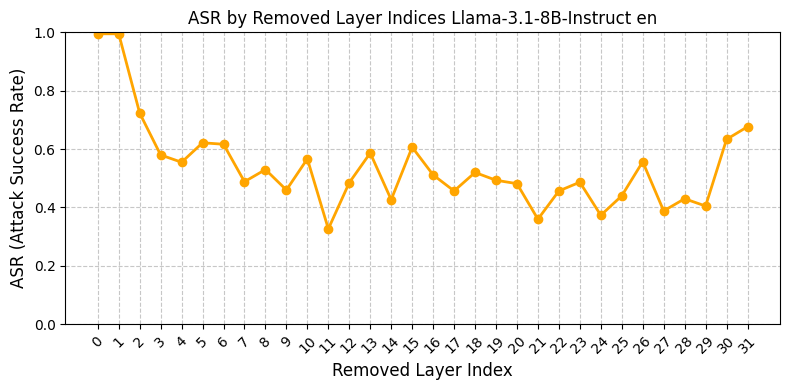

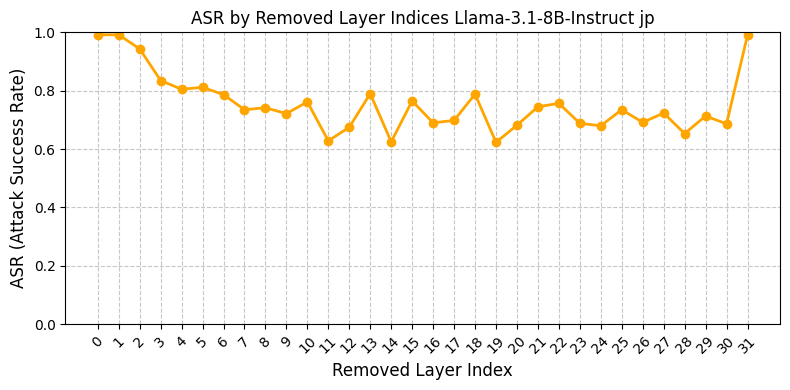

FileNotFoundError: [WinError 3] 指定されたパスが見つかりません。: './Llama-3.2-3B-Instruct_ja'

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import re

def load_reject_phrases(file_path: str):
    if not os.path.exists(file_path):
        print(f"[WARN] {file_path} が見つかりません．空リストを返します．")
        return []
    with open(file_path, "r", encoding="utf-8") as f:
        phrases = [line.strip() for line in f if line.strip()]
    return phrases

def extract_layer_number(folder_name):
    match = re.search(r"\[(\d+)\]", folder_name)
    return int(match.group(1)) if match else float('inf')

def compute_asr_from_results(result_dir, reject_phrases):
    results = {}
    for folder in sorted(os.listdir(result_dir), key=extract_layer_number):
        folder_path = os.path.join(result_dir, folder)
        csv_path = os.path.join(folder_path, "generated.csv")
        if os.path.exists(csv_path):
            df = pd.read_csv(csv_path)
            generated_texts = df["generated_text"].astype(str).tolist()
            reject_count = sum(1 for text in generated_texts if any(phrase in text for phrase in reject_phrases))
            total = len(generated_texts)
            asr = (1 - (reject_count / total)) if total > 0 else 0.0
            results[extract_layer_number(folder)] = asr
    return results

def plot_asr_graph(results, model_name, lang):
    sorted_layers = sorted(results.keys())
    x = sorted_layers
    y = [results[layer] for layer in sorted_layers]
    model_name_pre = model_name.split("_")[0]
    plt.figure(figsize=(8, 4))
    plt.plot(x, y, marker='o', linestyle='-', linewidth=2, color='orange')
    plt.xlabel("Removed Layer Index", fontsize=12)
    plt.ylabel("ASR (Attack Success Rate)", fontsize=12)
    plt.ylim(0, 1)  # 縦軸の範囲を 0 から 1 に固定
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(x, labels=x, rotation=45, fontsize=10)  # X軸ラベルは層番号のみ
    plt.title(f"ASR by Removed Layer Indices {model_name_pre} {lang}")
    plt.tight_layout()
    plt.savefig(f"asr_by_layer_removal_{model_name_pre}_{lang}.png")
    plt.show()


def main():
    model_name = "Llama-3.1-8B-Instruct_en"
    result_dir = f"./{model_name}"
    reject_sentence_path = "./reject_keywords_en_.txt"
    reject_phrases = load_reject_phrases(reject_sentence_path)
    results = compute_asr_from_results(result_dir, reject_phrases)
    plot_asr_graph(results, model_name, "en")


    model_name = "Llama-3.1-8B-Instruct_ja"
    result_dir = f"./{model_name}"
    reject_sentence_path = "./reject_keywords_ja_.txt"
    reject_phrases = load_reject_phrases(reject_sentence_path)
    results = compute_asr_from_results(result_dir, reject_phrases)
    plot_asr_graph(results, model_name, "jp")

if __name__ == "__main__":
    main()
